# 3-1,低阶API示范

下面的范例使用TensorFlow的低阶API实现线性回归模型和DNN二分类模型。

低阶API主要包括张量操作，计算图和自动微分。

In [1]:
import tensorflow as tf

#打印时间分割线
@tf.function
def printbar():
    today_ts = tf.timestamp()%(24*60*60)

    hour = tf.cast(today_ts//3600+8,tf.int32)%tf.constant(24)
    minite = tf.cast((today_ts%3600)//60,tf.int32)
    second = tf.cast(tf.floor(today_ts%60),tf.int32)
    
    def timeformat(m):
        if tf.strings.length(tf.strings.format("{}",m))==1:
            return(tf.strings.format("0{}",m))
        else:
            return(tf.strings.format("{}",m))
    
    timestring = tf.strings.join([timeformat(hour),timeformat(minite),
                timeformat(second)],separator = ":")
    tf.print("=========="*8+timestring)

# 一，线性回归模型
1，准备数据

In [2]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt 
import tensorflow as tf


#样本数量
n = 400

# 生成测试用数据集
X = tf.random.uniform([n,2],minval=-10,maxval=10) 
w0 = tf.constant([[2.0],[-3.0]])
b0 = tf.constant([[3.0]])
Y = X@w0 + b0 + tf.random.normal([n,1],mean = 0.0,stddev= 2.0)  # @表示矩阵乘法,增加正态扰动


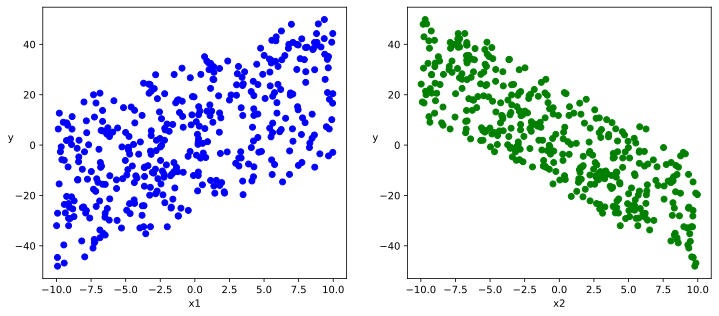

In [3]:
# 数据可视化

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.scatter(X[:,0],Y[:,0], c = "b")
plt.xlabel("x1")
plt.ylabel("y",rotation = 0)

ax2 = plt.subplot(122)
ax2.scatter(X[:,1],Y[:,0], c = "g")
plt.xlabel("x2")
plt.ylabel("y",rotation = 0)
plt.show()

In [4]:
# 构建数据管道迭代器
def data_iter(features, labels, batch_size=8):
    num_examples = len(features)
    indices = list(range(num_examples))
    np.random.shuffle(indices)  #样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        indexs = indices[i: min(i + batch_size, num_examples)]
        yield tf.gather(features,indexs), tf.gather(labels,indexs)
        
# 测试数据管道效果   
batch_size = 8
(features,labels) = next(data_iter(X,Y,batch_size))
print(features)
print(labels)

tf.Tensor(
[[ 0.70074844 -8.733732  ]
 [-0.84331036 -1.3261299 ]
 [-4.3738556   4.362009  ]
 [-4.599037   -8.400087  ]
 [ 4.264741    7.058508  ]
 [-7.0916486   1.4083366 ]
 [ 5.931694    1.047678  ]
 [-9.920675    3.1252022 ]], shape=(8, 2), dtype=float32)
tf.Tensor(
[[ 35.09045  ]
 [  7.07782  ]
 [-14.895711 ]
 [ 15.1104355]
 [ -8.63342  ]
 [-13.385143 ]
 [ 12.700143 ]
 [-27.047693 ]], shape=(8, 1), dtype=float32)


## 2，定义模型

In [5]:
w = tf.Variable(tf.random.normal(w0.shape))
b = tf.Variable(tf.zeros_like(b0,dtype = tf.float32))

# 定义模型
class LinearRegression:     
    #正向传播
    def __call__(self,x): 
        return x@w + b

    # 损失函数
    def loss_func(self,y_true,y_pred):  
        return tf.reduce_mean((y_true - y_pred)**2/2)

model = LinearRegression()

## 3，训练模型

In [7]:
# 使用动态图调试
def train_step(model, features, labels):
    with tf.GradientTape() as tape:
        predictions = model(features)
        loss = model.loss_func(labels, predictions)
    # 反向传播求梯度
    dloss_dw,dloss_db = tape.gradient(loss,[w,b])
    # 梯度下降法更新参数
    w.assign(w - 0.001*dloss_dw)
    b.assign(b - 0.001*dloss_db)
    
    return loss

In [8]:
# 测试train_step效果
batch_size = 10
(features,labels) = next(data_iter(X,Y,batch_size))
train_step(model,features,labels)

<tf.Tensor: shape=(), dtype=float32, numpy=270.6984>

In [9]:
def train_model(model,epochs):
    for epoch in tf.range(1,epochs+1):
        for features, labels in data_iter(X,Y,10):
            loss = train_step(model,features,labels)

        if epoch%50==0:
            printbar()
            tf.print("epoch =",epoch,"loss = ",loss)
            tf.print("w =",w)
            tf.print("b =",b)

train_model(model,epochs = 200)

================================================================================00:50:17
epoch = 50 loss =  2.88984036
w = [[1.9982394]
 [-2.96644354]]
b = [[2.67632604]]
================================================================================00:50:19
epoch = 100 loss =  2.32242918
w = [[1.99866498]
 [-2.9604547]]
b = [[3.04393625]]
================================================================================00:50:22
epoch = 150 loss =  3.26298952
w = [[2.00335431]
 [-2.96279955]]
b = [[3.09369326]]
================================================================================00:50:24
epoch = 200 loss =  0.909915805
w = [[2.00614929]
 [-2.96614647]]
b = [[3.10055065]]


In [10]:
##使用autograph机制转换成静态图加速

@tf.function
def train_step(model, features, labels):
    with tf.GradientTape() as tape:
        predictions = model(features)
        loss = model.loss_func(labels, predictions)
    # 反向传播求梯度
    dloss_dw,dloss_db = tape.gradient(loss,[w,b])
    # 梯度下降法更新参数
    w.assign(w - 0.001*dloss_dw)
    b.assign(b - 0.001*dloss_db)
    
    return loss

def train_model(model,epochs):
    for epoch in tf.range(1,epochs+1):
        for features, labels in data_iter(X,Y,10):
            loss = train_step(model,features,labels)
        if epoch%50==0:
            printbar()
            tf.print("epoch =",epoch,"loss = ",loss)
            tf.print("w =",w)
            tf.print("b =",b)

train_model(model,epochs = 200)

================================================================================00:50:40
epoch = 50 loss =  0.802594066
w = [[2.00757504]
 [-2.97114277]]
b = [[3.10256457]]
================================================================================00:50:40
epoch = 100 loss =  4.12294626
w = [[2.00756955]
 [-2.96108556]]
b = [[3.10225463]]
================================================================================00:50:41
epoch = 150 loss =  2.35276771
w = [[2.00003695]
 [-2.96486664]]
b = [[3.10258365]]
================================================================================00:50:42
epoch = 200 loss =  2.55049586
w = [[1.99435759]
 [-2.96555972]]
b = [[3.10271025]]


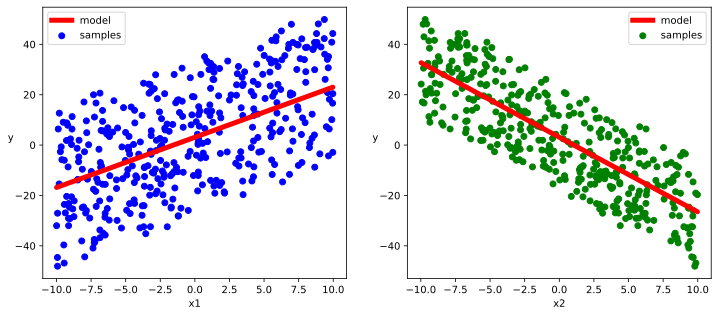

In [13]:
# 结果可视化

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.scatter(X[:,0],Y[:,0], c = "b",label = "samples")
ax1.plot(X[:,0],w[0]*X[:,0]+b[0],"-r",linewidth = 5.0,label = "model")
ax1.legend()
plt.xlabel("x1")
plt.ylabel("y",rotation = 0)


ax2 = plt.subplot(122)
ax2.scatter(X[:,1],Y[:,0], c = "g",label = "samples")
ax2.plot(X[:,1],w[1]*X[:,1]+b[0],"-r",linewidth = 5.0,label = "model")
ax2.legend()
plt.xlabel("x2")
plt.ylabel("y",rotation = 0)

plt.show()

## 二，DNN二分类模型
### 1，准备数据

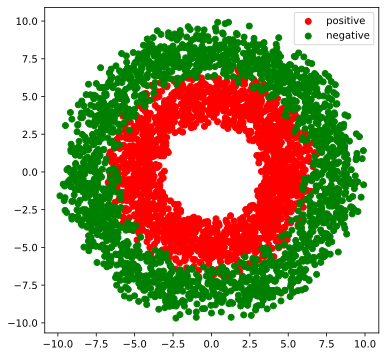

In [14]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import tensorflow as tf
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#正负样本数量
n_positive,n_negative = 2000,2000

#生成正样本, 小圆环分布
r_p = 5.0 + tf.random.truncated_normal([n_positive,1],0.0,1.0)
theta_p = tf.random.uniform([n_positive,1],0.0,2*np.pi) 
Xp = tf.concat([r_p*tf.cos(theta_p),r_p*tf.sin(theta_p)],axis = 1)
Yp = tf.ones_like(r_p)

#生成负样本, 大圆环分布
r_n = 8.0 + tf.random.truncated_normal([n_negative,1],0.0,1.0)
theta_n = tf.random.uniform([n_negative,1],0.0,2*np.pi) 
Xn = tf.concat([r_n*tf.cos(theta_n),r_n*tf.sin(theta_n)],axis = 1)
Yn = tf.zeros_like(r_n)

#汇总样本
X = tf.concat([Xp,Xn],axis = 0)
Y = tf.concat([Yp,Yn],axis = 0)


#可视化
plt.figure(figsize = (6,6))
plt.scatter(Xp[:,0].numpy(),Xp[:,1].numpy(),c = "r")
plt.scatter(Xn[:,0].numpy(),Xn[:,1].numpy(),c = "g")
plt.legend(["positive","negative"]);

In [15]:
# 构建数据管道迭代器
def data_iter(features, labels, batch_size=8):
    num_examples = len(features)
    indices = list(range(num_examples))
    np.random.shuffle(indices)  #样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        indexs = indices[i: min(i + batch_size, num_examples)]
        yield tf.gather(features,indexs), tf.gather(labels,indexs)
        
# 测试数据管道效果   
batch_size = 10
(features,labels) = next(data_iter(X,Y,batch_size))
print(features)
print(labels)

tf.Tensor(
[[ 4.392284    5.8774996 ]
 [ 0.08537193 -4.5291996 ]
 [ 1.0426594   8.710463  ]
 [ 2.7604928  -3.1311924 ]
 [-4.196341   -3.155712  ]
 [-0.7613455   8.060124  ]
 [-7.7428017  -2.2715507 ]
 [-1.4814608   4.5570087 ]
 [ 5.6262393  -0.68515766]
 [-5.3525295  -3.025476  ]], shape=(10, 2), dtype=float32)
tf.Tensor(
[[0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]], shape=(10, 1), dtype=float32)


## 2，定义模型

此处范例我们利用tf.Module来组织模型变量，关于tf.Module的较详细介绍参考本书第四章最后一节: Autograph和tf.Module。

In [16]:
class DNNModel(tf.Module):
    def __init__(self,name = None):
        super(DNNModel, self).__init__(name=name)
        self.w1 = tf.Variable(tf.random.truncated_normal([2,4]),dtype = tf.float32)
        self.b1 = tf.Variable(tf.zeros([1,4]),dtype = tf.float32)
        self.w2 = tf.Variable(tf.random.truncated_normal([4,8]),dtype = tf.float32)
        self.b2 = tf.Variable(tf.zeros([1,8]),dtype = tf.float32)
        self.w3 = tf.Variable(tf.random.truncated_normal([8,1]),dtype = tf.float32)
        self.b3 = tf.Variable(tf.zeros([1,1]),dtype = tf.float32)

     
    # 正向传播
    @tf.function(input_signature=[tf.TensorSpec(shape = [None,2], dtype = tf.float32)])  
    def __call__(self,x):
        x = tf.nn.relu(x@self.w1 + self.b1)
        x = tf.nn.relu(x@self.w2 + self.b2)
        y = tf.nn.sigmoid(x@self.w3 + self.b3)
        return y
    
    # 损失函数(二元交叉熵)
    @tf.function(input_signature=[tf.TensorSpec(shape = [None,1], dtype = tf.float32),
                              tf.TensorSpec(shape = [None,1], dtype = tf.float32)])  
    def loss_func(self,y_true,y_pred):  
        #将预测值限制在 1e-7 以上, 1 - 1e-7 以下，避免log(0)错误
        eps = 1e-7
        y_pred = tf.clip_by_value(y_pred,eps,1.0-eps)
        bce = - y_true*tf.math.log(y_pred) - (1-y_true)*tf.math.log(1-y_pred)
        return  tf.reduce_mean(bce)
    
    # 评估指标(准确率)
    @tf.function(input_signature=[tf.TensorSpec(shape = [None,1], dtype = tf.float32),
                              tf.TensorSpec(shape = [None,1], dtype = tf.float32)]) 
    def metric_func(self,y_true,y_pred):
        y_pred = tf.where(y_pred>0.5,tf.ones_like(y_pred,dtype = tf.float32),
                          tf.zeros_like(y_pred,dtype = tf.float32))
        acc = tf.reduce_mean(1-tf.abs(y_true-y_pred))
        return acc
    
model = DNNModel()

In [17]:
# 测试模型结构
batch_size = 10
(features,labels) = next(data_iter(X,Y,batch_size))

predictions = model(features)

loss = model.loss_func(labels,predictions)
metric = model.metric_func(labels,predictions)

tf.print("init loss:",loss)
tf.print("init metric",metric)

init loss: 1.50709558
init metric 0.5


In [18]:
print(len(model.trainable_variables))

6


## 3，训练模型

In [19]:
##使用autograph机制转换成静态图加速

@tf.function
def train_step(model, features, labels):
    
    # 正向传播求损失
    with tf.GradientTape() as tape:
        predictions = model(features)
        loss = model.loss_func(labels, predictions) 
        
    # 反向传播求梯度
    grads = tape.gradient(loss, model.trainable_variables)
    
    # 执行梯度下降
    for p, dloss_dp in zip(model.trainable_variables,grads):
        p.assign(p - 0.001*dloss_dp)
        
    # 计算评估指标
    metric = model.metric_func(labels,predictions)
    
    return loss, metric


def train_model(model,epochs):
    for epoch in tf.range(1,epochs+1):
        for features, labels in data_iter(X,Y,100):
            loss,metric = train_step(model,features,labels)
        if epoch%100==0:
            printbar()
            tf.print("epoch =",epoch,"loss = ",loss, "accuracy = ", metric)
        

train_model(model,epochs = 600)

================================================================================00:53:24
epoch = 100 loss =  0.642536223 accuracy =  0.57
================================================================================00:53:26
epoch = 200 loss =  0.611600339 accuracy =  0.62
================================================================================00:53:28
epoch = 300 loss =  0.539549053 accuracy =  0.78
================================================================================00:53:30
epoch = 400 loss =  0.565830946 accuracy =  0.77
================================================================================00:53:32
epoch = 500 loss =  0.528839171 accuracy =  0.77
================================================================================00:53:34
epoch = 600 loss =  0.441862881 accuracy =  0.93


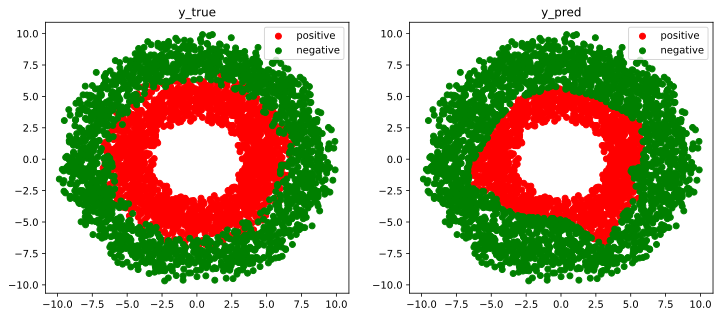

In [20]:
# 结果可视化
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize = (12,5))
ax1.scatter(Xp[:,0],Xp[:,1],c = "r")
ax1.scatter(Xn[:,0],Xn[:,1],c = "g")
ax1.legend(["positive","negative"]);
ax1.set_title("y_true");

Xp_pred = tf.boolean_mask(X,tf.squeeze(model(X)>=0.5),axis = 0)
Xn_pred = tf.boolean_mask(X,tf.squeeze(model(X)<0.5),axis = 0)

ax2.scatter(Xp_pred[:,0],Xp_pred[:,1],c = "r")
ax2.scatter(Xn_pred[:,0],Xn_pred[:,1],c = "g")
ax2.legend(["positive","negative"]);
ax2.set_title("y_pred");